In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

### 데이터 세트 불러오기

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
data_df = pd.concat([train_df, test_df])

### 피처 엔지니어링

In [3]:
data_df['Title'] = data_df['Name']

# name 값에서 호칭을 추출한다. 
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# 이름의 격식 칭호를 가장 보편적인 것으로 묶어 분류한다. 
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']

# 각 호칭 별로 나이의 중앙값을 구해 빈 나이값을 채운다.
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Train과 Test 데이터 안의 Age 값을 분리한다. 
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Title 컬럼을 드랍한다. 
data_df.drop('Title', axis=1, inplace = True)

In [5]:
# 타이타닉 내 가족의 크기는 같이 승선한 형제자매, 부모님, 자녀의 수를 모두 더한 값이다.
data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp'] + 1 

# Train과 Test 데이터 안의 Family_Size 값을 분리한다. 
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]

In [6]:
# 성(Last Name)을 추출하고, Fare의 빈 값을 중앙값으로 채운다.
data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

# DRS(Default Survival Value)를 50%로 설정한다. 
DRS = 0.5
data_df['Family_Survival'] = DRS

# 그룹 별로 Fare와 Last Name을 기준으로 그룹을 나눈다. 
for grp, grp_df in data_df[['Survived', 'Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    # 만약 그룹의 크기가 1이 아니라면, 즉 가족이 있다면 
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            # 해당 사람의 생존률 최대와 최소를 구해 저장한다. 
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            # 해당 사람의 승객 번호를 저장한다.
            passID = row['PassengerId']
            if (smax == 1.0):
                # 생존률이 1이면 가족이 모두 생존했다는 것이므로 1로 설정한다.
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

# 가족이 있는 승객의 수를 출력한다. 
print("동승한 한 명의 이상의 가족의 생존 정보가 있는 승객의 수를 출력:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

동승한 한 명의 이상의 가족의 생존 정보가 있는 승객의 수를 출력: 420


In [7]:
# Ticket을 기준으로 그룹을 나눈다. 
for _, grp_df in data_df.groupby('Ticket'):
    # 만약 그룹의 크기가 1이 아니라면, 즉 혼자가 아니라면 
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            # 혼자가 아닌 승객의 생존률 최대와 최소를 구해 저장한다.
            if (row['Family_Survival']==0) or (row['Family_Survival']==0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax==1.0):
                    # 생존률이 1이면 가족 또는 일행이 생존했다는 것이므로 1로 설정한다.
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("가족 또는 일행의 생존 정보가 있는 승객의 수를 출력: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# Train과 Test 데이터 안의 Family_Survival 값을 분리한다. 
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]

가족 또는 일행의 생존 정보가 있는 승객의 수를 출력: 546


In [8]:
# Fare(요금)의 결측치를 중앙값으로 채운다.
data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Fare 값을 5개의 구간으로 나누어 묶음들을 생성한다. 
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

# FareBin을 LabelEncoder를 사용해 숫자로 변환한다.
label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

# Train과 Test 데이터 안의 Farebin_Code를 분리한다. 
train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

# Train과 Test 내에서 Fare을 제거한다. 
train_df.drop(['Fare'], 1, inplace=True)
test_df.drop(['Fare'], 1, inplace=True)

C:\Users\jj\AppData\Local\Temp\ipykernel_13216\324186186.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_df.drop(['Fare'], 1, inplace=True)
C:\Users\jj\AppData\Local\Temp\ipykernel_13216\324186186.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_df.drop(['Fare'], 1, inplace=True)


In [9]:
# Age를 4개의 구간으로 나누어 묶음들을 생성한다.
data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

# AgeBin을 LabelEncoder를 사용해 숫자로 변환한다.
label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

# Train과 Test 데이터 안의 AgeBin_Code를 분리한다.
train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

# Train과 Test 내에서 Age를 제거한다.
train_df.drop(['Age'], 1, inplace=True)
test_df.drop(['Age'], 1, inplace=True)

C:\Users\jj\AppData\Local\Temp\ipykernel_13216\390048774.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_df.drop(['Age'], 1, inplace=True)
C:\Users\jj\AppData\Local\Temp\ipykernel_13216\390048774.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_df.drop(['Age'], 1, inplace=True)


In [10]:
# train과 test 내에서 Sex(성별)을 숫자로 변환한다.
train_df['Sex'].replace(['male','female'],[0,1], inplace=True)
test_df['Sex'].replace(['male','female'],[0,1], inplace=True)

# 불필요한 데이터들이 영향을 주지 않도록 제거한다.
train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)

In [11]:
# 데이터 전처리 완료 후 train 데이터를 출력한다.
train_df.head(3)

pd.DataFrame(train_df).to_csv('file_train.csv', index=False)
pd.DataFrame(test_df).to_csv('file_test.csv', index=False)

### 모델 지정 및 학습 

In [12]:
# Train 내에서 Survived를 분리하고 X로 지정한다. 분리된 Survived를 y로 지정한다. 
X = train_df.drop('Survived', 1)
y = train_df['Survived']

# Test 데이터를 X_test로 지정한다.
X_test = test_df.copy()

C:\Users\jj\AppData\Local\Temp\ipykernel_13216\2219917995.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train_df.drop('Survived', 1)


In [13]:
# StandardScaler를 사용해 데이터를 정규화한다.
std_scaler = StandardScaler()

# Train과 Test 데이터를 정규화한다. 이 때 공통적으로 StandardScaler를 사용한다.
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)


In [14]:
# KNN 모델을 사용하기 위한 밑작업으로 하이퍼파라미터를 설정한다.
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

# 설정값을 바탕으로 GridSearchCV를 사용해 최적의 하이퍼파라미터를 찾는다.
gd = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")

gd.fit(X, y)
# 최적의 하이퍼파라미터를 출력한다.
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
0.8783650227767875
KNeighborsClassifier(leaf_size=26, n_neighbors=16)


In [15]:
# 도출한 최적의 파라미터를 X와 y에 적용한다.
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_test)

c:\Cookiebake\envs\Walter\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [16]:
# 도출된 최적의 하이퍼파라미터를 사용해 KNN 모델을 생성한다.
# 위에서 제시된 n_neighbors 값은 16이지만, 보다 간단한 접근을 위해 수를 줄인다. 
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')
# KNN 모델을 X와 y에 적용한다. 
knn.fit(X, y)
y_pred = knn.predict(X_test)

c:\Cookiebake\envs\Walter\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### 제출 

In [17]:
# 제출할 csv 파일을 생성한다.
temp = pd.DataFrame(pd.read_csv("test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("submission_knn.csv", index = False)

### Kaggle Titanic 도전 마무리 (2024년 8월 25일)
#### 최종 점수 82.78%

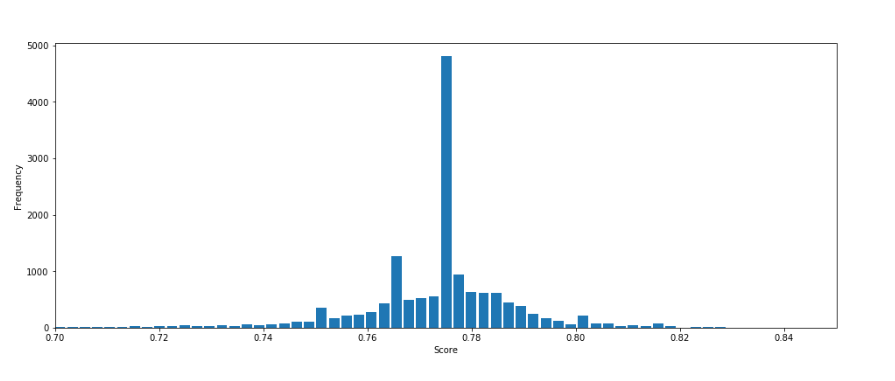

In [18]:
# load titanicchart.png
from IPython.display import Image
Image("titanicchart.png")
Image("titanicgraph.png")

* 날이 갈수록 1.0 득점자가 많아져서, 점수 올릴 보람을 더 이상 느끼지 않습니다. 
* 0.8을 초과한 점수는 상위 5.42%라 볼 수 있는 바, 이 기록을 다른 사람의 가이드 없이 스스로 도출한 것에 만족하며 타이타닉에서 하선하겠습니다. 

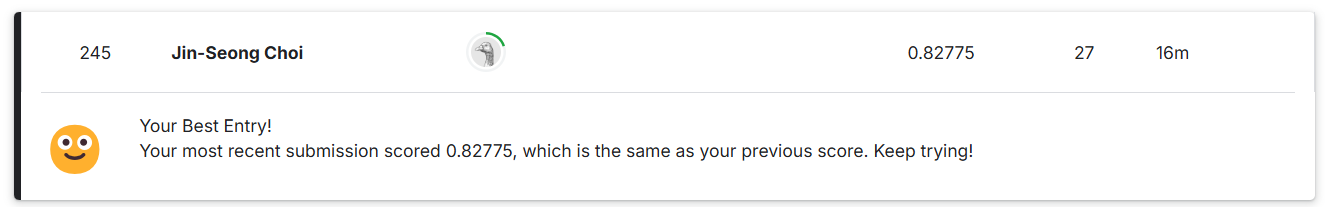

In [19]:
Image("245th.png")